## Reading and Understanding the Dataset
This section imports necessary libraries, mounts Google Drive, loads the gold dataset, and explores its structure.

In [9]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
file_path = '/content/drive/MyDrive/graduation project/Gold_Data/data.csv'  # Replace with the correct file path
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(df.head())

# Examine the structure and data types
print(df.info())

# Check for missing values
print(df.isna().sum())

# Descriptive statistics
print(df.describe())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
         Date  24K - Local Price/Sell  24K - Local Price/Buy  \
0  2022-11-09                  1394.0                 1401.0   
1  2022-11-10                  1398.0                 1402.0   
2  2022-11-11                  1431.0                 1435.0   
3  2022-11-12                  1446.0                 1457.0   
4  2022-11-13                  1429.0                 1440.0   

   22K - Local Price/Sell  22K - Local Price/Buy  21K - Local Price/Sell  \
0                  1278.0                 1284.0                  1220.0   
1                  1281.0                 1285.0                  1223.0   
2                  1312.0                 1316.0                  1252.0   
3                  1325.0                 1336.0                  1265.0   
4                  1310.0                 1320.0                  1250.0   

   21K - Local Price/Buy  18K

## Data Preprocessing
This section handles missing values and prepares the data for forecasting.

In [10]:
# Fill missing values with the mean for numeric columns only
numeric_columns = df.select_dtypes(include=np.number).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Convert 'Date' to datetime if it's not already datetime and then set as index
# Check if 'Date' is already the index
if 'Date' not in df.index.names:
    # If 'Date' is a column, convert it to datetime and set as index
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
    else:
        print("Warning: 'Date' column not found in the DataFrame.")

# Display the updated dataset
print(df.head())
print(df.isna().sum())


            24K - Local Price/Sell  24K - Local Price/Buy  \
Date                                                        
2022-11-09                  1394.0                 1401.0   
2022-11-10                  1398.0                 1402.0   
2022-11-11                  1431.0                 1435.0   
2022-11-12                  1446.0                 1457.0   
2022-11-13                  1429.0                 1440.0   

            22K - Local Price/Sell  22K - Local Price/Buy  \
Date                                                        
2022-11-09                  1278.0                 1284.0   
2022-11-10                  1281.0                 1285.0   
2022-11-11                  1312.0                 1316.0   
2022-11-12                  1325.0                 1336.0   
2022-11-13                  1310.0                 1320.0   

            21K - Local Price/Sell  21K - Local Price/Buy  \
Date                                                        
2022-11-09            

## Exploratory Data Analysis (EDA)
This section explores the dataset through visualizations and statistical methods.

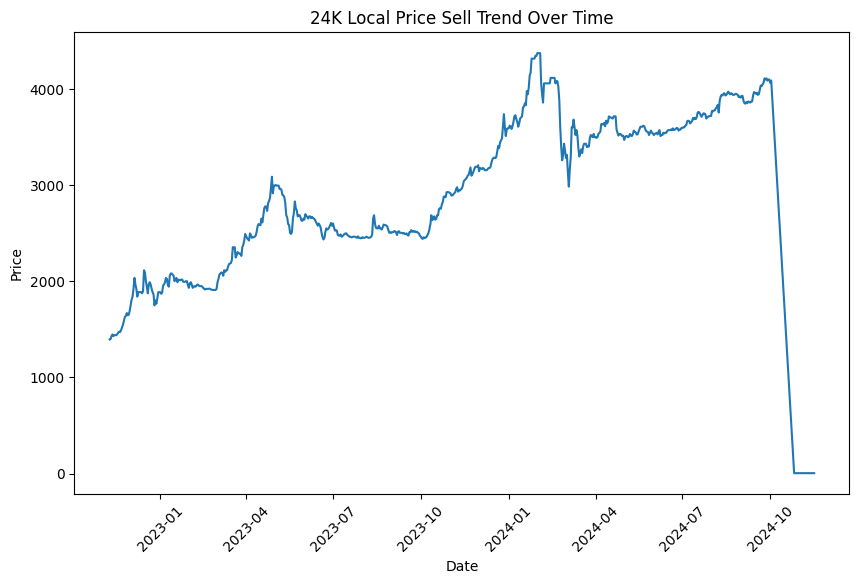

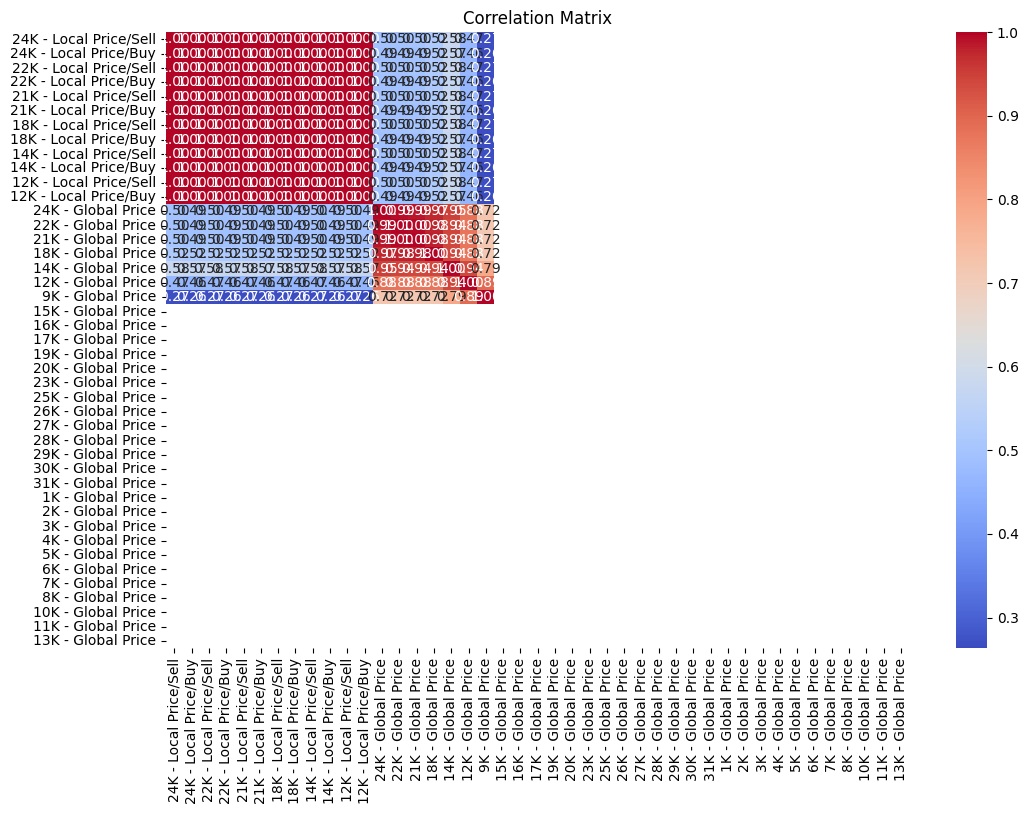

In [11]:

# Visualize 24K Sell Price Trend Over Time
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x=df.index, y='24K - Local Price/Sell')
plt.title('24K Local Price Sell Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

# Correlation matrix heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


## Forecasting Models
This section applies ARIMA, SARIMA, Prophet, Random Forest, and Gradient Boosting models to forecast gold prices.

### Forecasting with ARIMA

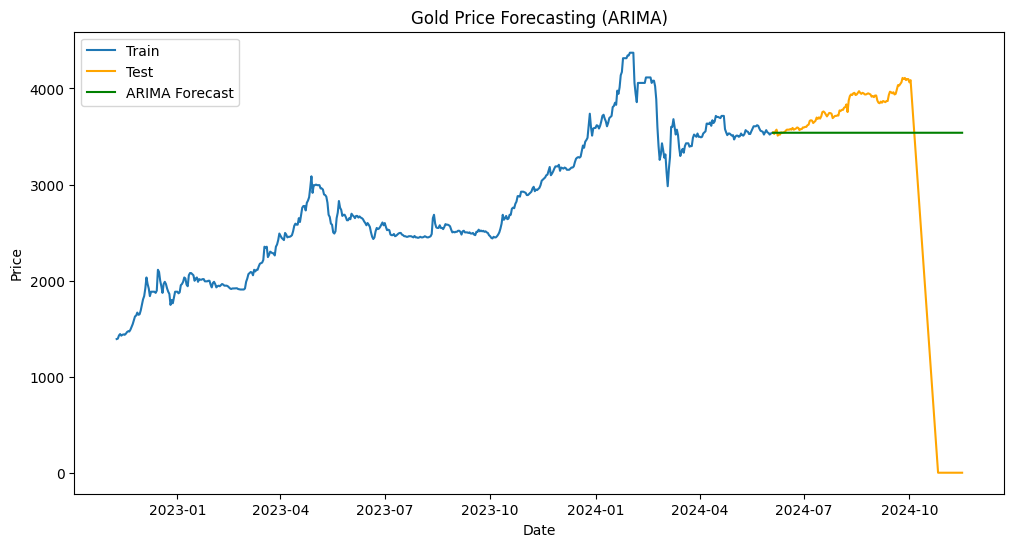

ARIMA MAE: 736.3280616456072, RMSE: 1387.9302022303925


In [12]:

# Select the target column for forecasting
gold_prices = df['24K - Local Price/Sell'].dropna()

# Train-test split
train_size = int(len(gold_prices) * 0.8)
train, test = gold_prices[:train_size], gold_prices[train_size:]

# Fit ARIMA model
arima_model = ARIMA(train, order=(1, 1, 1))
arima_fitted = arima_model.fit()

# Forecast
arima_forecast = arima_fitted.forecast(steps=len(test))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='orange')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='green')
plt.title('Gold Price Forecasting (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Evaluate
arima_mae = mean_absolute_error(test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
print(f"ARIMA MAE: {arima_mae}, RMSE: {arima_rmse}")


### Forecasting with SARIMA

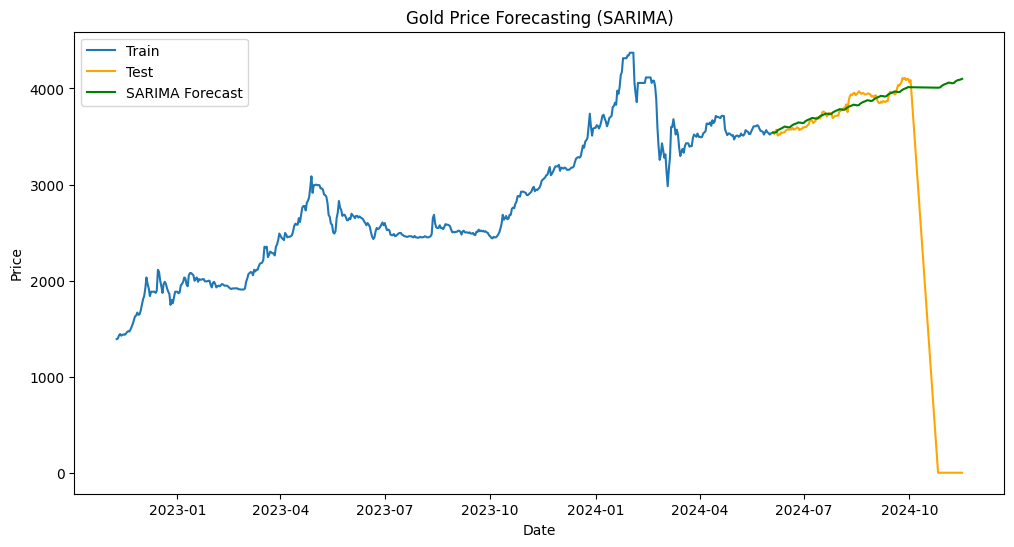

SARIMA MAE: 642.0350049531236, RMSE: 1558.4302679383982


In [13]:

# Fit SARIMA model
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fitted = sarima_model.fit(disp=False)

# Forecast
sarima_forecast = sarima_fitted.forecast(steps=len(test))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='orange')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green')
plt.title('Gold Price Forecasting (SARIMA)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Evaluate
sarima_mae = mean_absolute_error(test, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
print(f"SARIMA MAE: {sarima_mae}, RMSE: {sarima_rmse}")


### Forecasting with Prophet

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoivlci0r/erwtyfqf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoivlci0r/usnyb60c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26706', 'data', 'file=/tmp/tmpoivlci0r/erwtyfqf.json', 'init=/tmp/tmpoivlci0r/usnyb60c.json', 'output', 'file=/tmp/tmpoivlci0r/prophet_modeln5w5_egb/prophet_model-20241127140007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:00:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:00:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


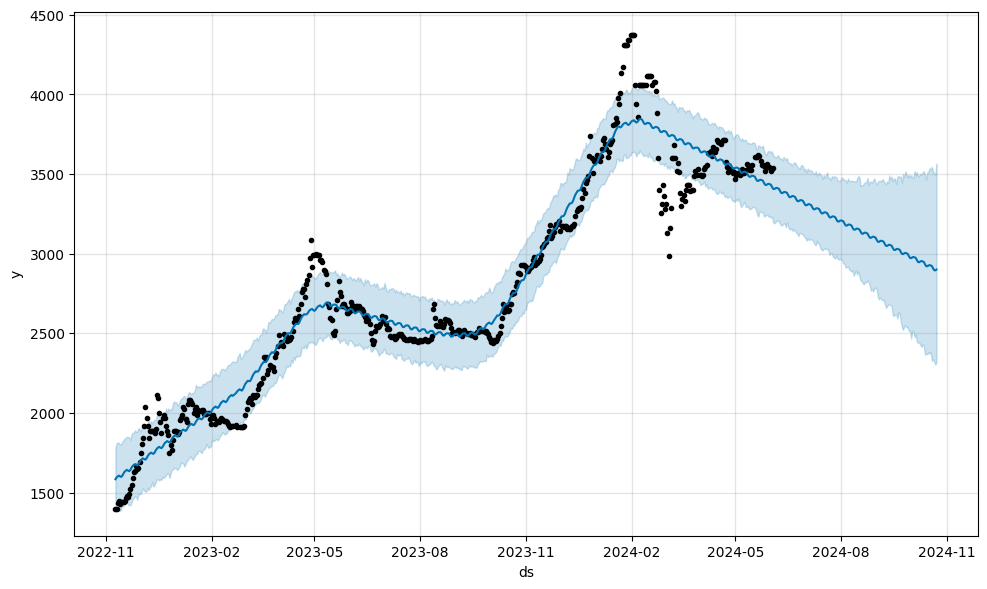

Prophet MAE: 938.678121520551, RMSE: 1283.1826126543542


In [14]:

# Prepare data for Prophet
prophet_data = gold_prices.reset_index()
prophet_data.columns = ['ds', 'y']

# Fit Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data.iloc[:train_size])

# Forecast
future = prophet_model.make_future_dataframe(periods=len(test))
forecast = prophet_model.predict(future)

# Plot
forecast_fig = prophet_model.plot(forecast)
plt.show()

# Evaluate
prophet_forecast = forecast.iloc[-len(test):]['yhat'].values
prophet_mae = mean_absolute_error(test, prophet_forecast)
prophet_rmse = np.sqrt(mean_squared_error(test, prophet_forecast))
print(f"Prophet MAE: {prophet_mae}, RMSE: {prophet_rmse}")


### Forecasting with Random Forest

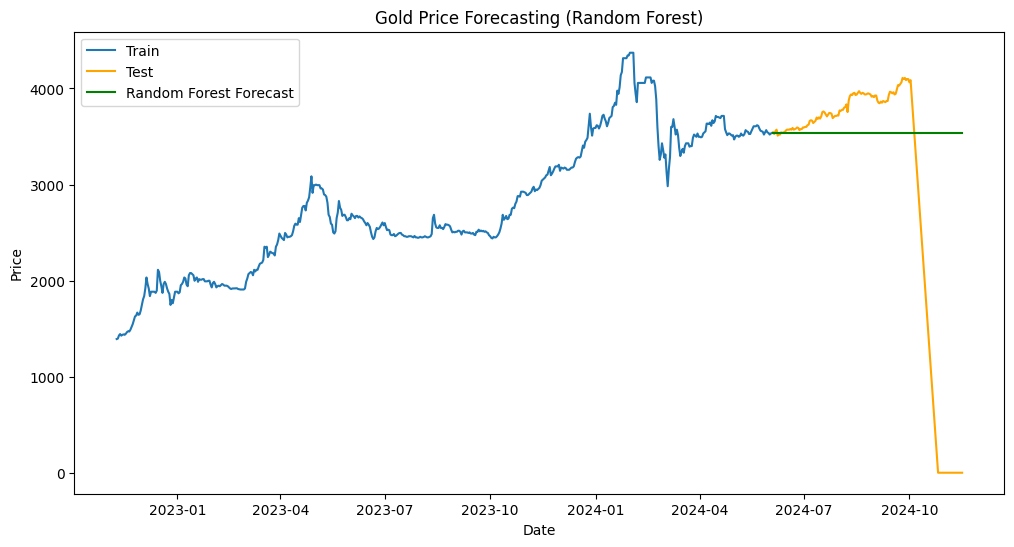

Random Forest MAE: 739.1721126760561, RMSE: 1386.9453035505203


In [15]:

# Prepare data for Random Forest
X_train_rf = np.arange(len(train)).reshape(-1, 1)
X_test_rf = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)

# Fit Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, train)

# Forecast
rf_forecast = rf_model.predict(X_test_rf)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='orange')
plt.plot(test.index, rf_forecast, label='Random Forest Forecast', color='green')
plt.title('Gold Price Forecasting (Random Forest)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Evaluate
rf_mae = mean_absolute_error(test, rf_forecast)
rf_rmse = np.sqrt(mean_squared_error(test, rf_forecast))
print(f"Random Forest MAE: {rf_mae}, RMSE: {rf_rmse}")


### Forecasting with Gradient Boosting

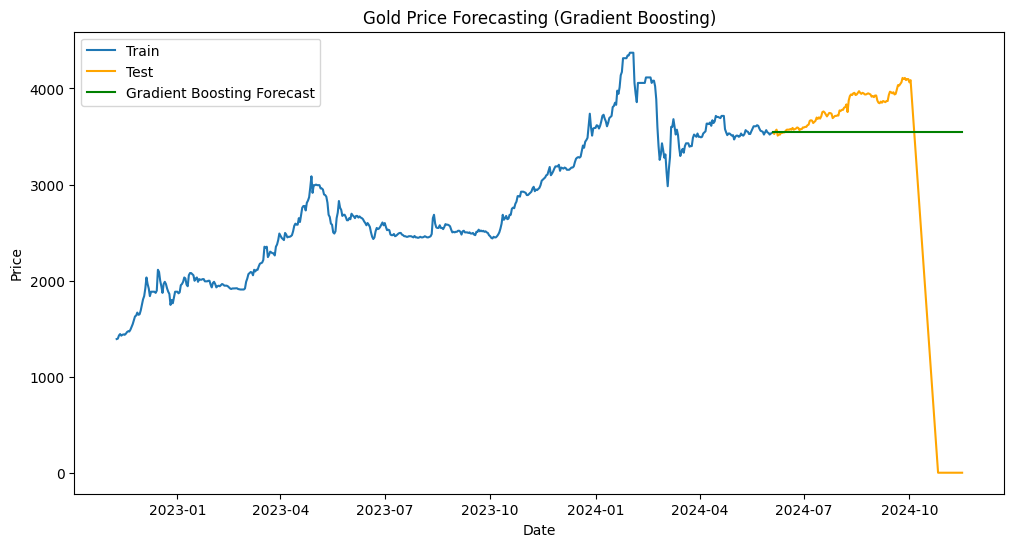

Gradient Boosting MAE: 732.709245390302, RMSE: 1389.2519425225894


In [16]:

# Fit Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_rf, train)

# Forecast
gb_forecast = gb_model.predict(X_test_rf)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='orange')
plt.plot(test.index, gb_forecast, label='Gradient Boosting Forecast', color='green')
plt.title('Gold Price Forecasting (Gradient Boosting)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Evaluate
gb_mae = mean_absolute_error(test, gb_forecast)
gb_rmse = np.sqrt(mean_squared_error(test, gb_forecast))
print(f"Gradient Boosting MAE: {gb_mae}, RMSE: {gb_rmse}")
